In [12]:
from dask.distributed import Client
from hats_import.pipeline import pipeline_with_client
from hats_import.catalog.arguments import ImportArguments

import hats
import lsdb
import numpy as np
import matplotlib.pyplot as plt

In [4]:
client = Client(n_workers=96, threads_per_worker=1, memory_limit="15GiB")
client

/home/kmalanch/.virtualenvs/photoD/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32819 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:32819/status,
Dashboard: http://127.0.0.1:32819/status,Workers: 96
Total threads: 96,Total memory: 1.41 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37181,Workers: 96
Dashboard: http://127.0.0.1:32819/status,Total threads: 96
Started: Just now,Total memory: 1.41 TiB
Comm: tcp://127.0.0.1:38149,Total threads: 1
Dashboard: http://127.0.0.1:43983/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:38777,


In [6]:
args = ImportArguments(
    sort_columns="source_id",
    ra_column="ra",
    dec_column="dec",
    input_path="/mnt/beegfs/scratch/data/Gaia-SDSS/fits/",
    file_reader="fits",
    output_artifact_name="Gaia-SDSS",
    output_path="/mnt/beegfs/scratch/data/Gaia-SDSS/hats/"
)

In [7]:
pipeline_with_client(args, client)

Planning  :   0%|          | 0/4 [00:00<?, ?it/s]

Mapping   :   0%|          | 0/19 [00:00<?, ?it/s]

Binning   :   0%|          | 0/2 [00:00<?, ?it/s]

Splitting :   0%|          | 0/19 [00:00<?, ?it/s]

Reducing  :   0%|          | 0/63 [00:00<?, ?it/s]

Finishing :   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
%time
import lsdb
h = lsdb.read_hats("/mnt/beegfs/scratch/data/Gaia-SDSS/hats/Gaia-SDSS/")
#s82.skymap(lambda df, a: np.log10(len(df)+1), order=9)

CPU times: user 7 μs, sys: 4 μs, total: 11 μs
Wall time: 21 μs


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel density map - Gaia-SDSS'}>)

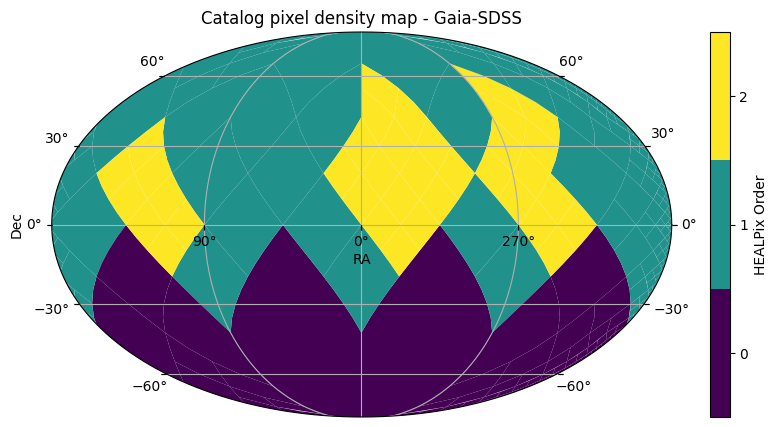

In [9]:
h.plot_pixels()

/home/kmalanch/.virtualenvs/photoD/lib/python3.10/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>, <WCSAxes: >)

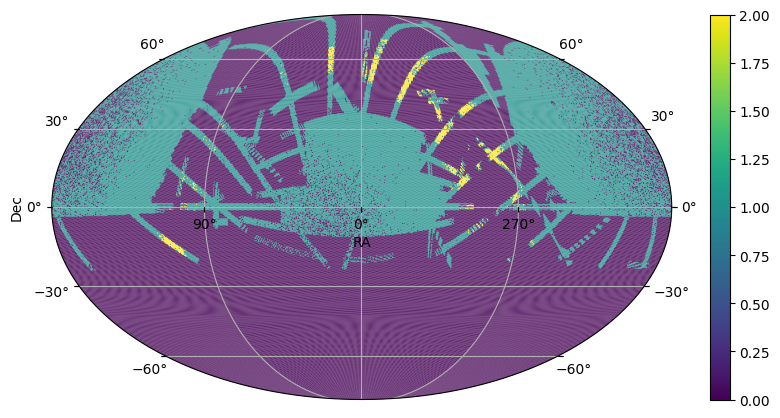

In [10]:
h.skymap(lambda df, a: np.log10(len(df)+1), order=9)

/home/kmalanch/.virtualenvs/photoD/lib/python3.10/site-packages/hats/inspection/visualize_catalog.py:309: UserWarning: This plot contains HEALPix pixels smaller than a pixel of the plot. Some values may be lost
  warnings.warn(


(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Angular density of catalog Gaia-SDSS'}>)

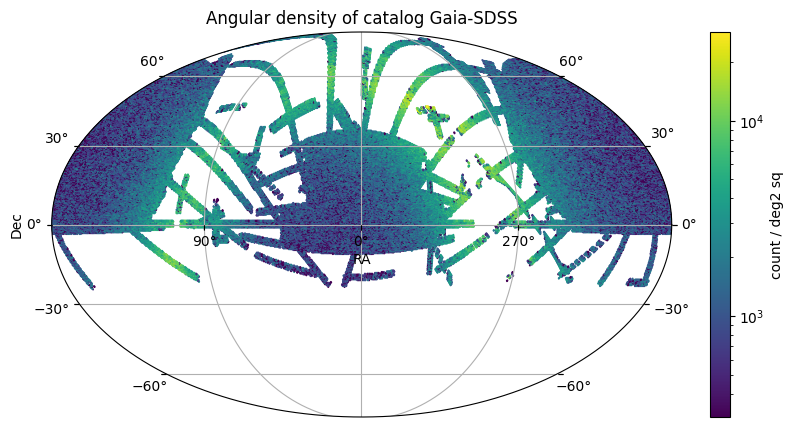

In [15]:
hats.inspection.plot_density(h.hc_structure, ec="face", norm='log')

Z-axis units? Log scale?

In [8]:
h.hc_structure.catalog_info

TableProperties(catalog_name='Gaia-SDSS', catalog_type='object', total_rows=27208817, ra_column='ra', dec_column='dec', default_columns=None, primary_catalog=None, margin_threshold=None, primary_column=None, primary_column_association=None, join_catalog=None, join_column=None, join_column_association=None, contains_leaf_files=None, indexing_column=None, extra_columns=None, hats_cols_sort='source_id', hats_max_rows='1000000', hats_order='2', moc_sky_fraction='1.00000', hats_builder='hats-import v0.4.3', hats_creation_date='2024-12-11T15:33UTC', hats_estsize='4144351', hats_release_date='2024-09-18', hats_version='v0.1')

Total number of rows checks out; 27'208,817 is also returned by the following GACS query:

```
SELECT COUNT(*)
	FROM gaiadr3.gaia_source AS G 
	JOIN external.gaiaedr3_distance AS D ON G.source_id = D.source_id 
	JOIN gaiadr3.sdssdr13_best_neighbour AS BN ON G.source_id = BN.source_id 
	JOIN external.sdssdr13_photoprimary AS S ON BN.original_ext_source_id = S.objid 
	WHERE G.parallax_over_error > 5 	
		AND G.visibility_periods_used > 10 	
		AND G.ruwe < 1.4 	
		AND G.in_qso_candidates = 'f' 	
		AND G.in_galaxy_candidates = 'f'
```

In [19]:
import dask.array

histG, binsG = dask.array.histogram(h["phot_g_mean_mag"], bins=np.linspace(4,25,100))
histgi, binsgi = dask.array.histogram(h["psfmag_g"]-h["psfmag_i"], bins=np.linspace(-5,5,100))
histG = histG.compute()
histgi = histgi.compute()

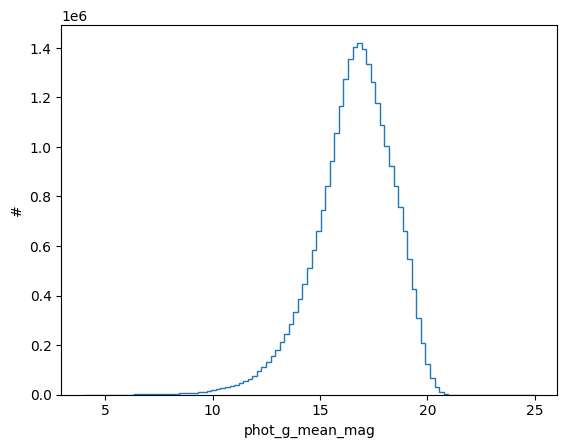

In [32]:
# Calculate bin widths for plotting
bin_widths = [binsG[i+1] - binsG[i] for i in range(len(bins) - 1)]

# Plot the histogram using bar
# plt.stairs(bins[:-1], histG, width=bin_widths, align='edge', edgecolor='black', alpha=0.7)
plt.stairs(histG, binsG)

# Add labels and title
plt.xlabel('phot_g_mean_mag')
plt.ylabel('#')
# plt.title('')

# Show plot
plt.show()

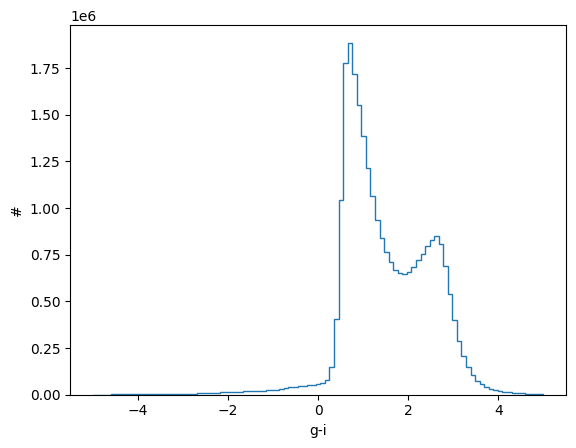

In [31]:
# Calculate bin widths for plotting
bin_widths = [binsgi[i+1] - bins[i] for i in range(len(bins) - 1)]

# Plot the histogram using bar
# plt.bar(bins[:-1], histgi, width=bin_widths, align='edge', edgecolor='black', alpha=0.7)
plt.stairs(histgi, binsgi)

# Add labels and title
plt.xlabel('g-i')
plt.ylabel('#')
# plt.title('')

# Show plot
plt.show()